In [ ]:
https://github.com/timesler/facenet-pytorch/blob/master/examples/face_tracking.ipynb

In [ ]:
!bash DeepFakeChallenge/setup.sh "whateveryourkeyis"

In [17]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [13]:
!unzip deepfake-detection-challenge.zip -d data

Archive:  deepfake-detection-challenge.zip
  inflating: data/sample_submission.csv  
  inflating: data/test_videos/aassnaulhq.mp4  
  inflating: data/test_videos/aayfryxljh.mp4  
  inflating: data/test_videos/acazlolrpz.mp4  
  inflating: data/test_videos/adohdulfwb.mp4  
  inflating: data/test_videos/ahjnxtiamx.mp4  
  inflating: data/test_videos/ajiyrjfyzp.mp4  
  inflating: data/test_videos/aktnlyqpah.mp4  
  inflating: data/test_videos/alrtntfxtd.mp4  
  inflating: data/test_videos/aomqqjipcp.mp4  
  inflating: data/test_videos/apedduehoy.mp4  
  inflating: data/test_videos/apvzjkvnwn.mp4  
  inflating: data/test_videos/aqrsylrzgi.mp4  
  inflating: data/test_videos/axfhbpkdlc.mp4  
  inflating: data/test_videos/ayipraspbn.mp4  
  inflating: data/test_videos/bcbqxhziqz.mp4  
  inflating: data/test_videos/bcvheslzrq.mp4  
  inflating: data/test_videos/bdshuoldwx.mp4  
  inflating: data/test_videos/bfdopzvxbi.mp4  
  inflating: data/test_videos/bfjsthfhbd.mp4  
  inflating: data/test

  inflating: data/test_videos/wndursivcx.mp4  
  inflating: data/test_videos/wnlubukrki.mp4  
  inflating: data/test_videos/wqysrieiqu.mp4  
  inflating: data/test_videos/wvgviwnwob.mp4  
  inflating: data/test_videos/wynotylpnm.mp4  
  inflating: data/test_videos/xcruhaccxc.mp4  
  inflating: data/test_videos/xdezcezszc.mp4  
  inflating: data/test_videos/xhtppuyqdr.mp4  
  inflating: data/test_videos/xitgdpzbxv.mp4  
  inflating: data/test_videos/xjvxtuakyd.mp4  
  inflating: data/test_videos/xljemofssi.mp4  
  inflating: data/test_videos/xmkwsnuzyq.mp4  
  inflating: data/test_videos/xphdfgmfmz.mp4  
  inflating: data/test_videos/xrtvqhdibb.mp4  
  inflating: data/test_videos/xugmhbetrw.mp4  
  inflating: data/test_videos/xxzefxwyku.mp4  
  inflating: data/test_videos/yarpxfqejd.mp4  
  inflating: data/test_videos/yaxgpxhavq.mp4  
  inflating: data/test_videos/ybbrkacebd.mp4  
  inflating: data/test_videos/yhjlnisfel.mp4  
  inflating: data/test_videos/yhylappzid.mp4  
  inflating: 

  inflating: data/train_sample_videos/bggsurpgpr.mp4  
  inflating: data/train_sample_videos/bghphrsfxf.mp4  
  inflating: data/train_sample_videos/bgmlwsoamc.mp4  
  inflating: data/train_sample_videos/bguwlyazau.mp4  
  inflating: data/train_sample_videos/bgvhtpzknn.mp4  
  inflating: data/train_sample_videos/bgwmmujlmc.mp4  
  inflating: data/train_sample_videos/bhaaboftbc.mp4  
  inflating: data/train_sample_videos/bhbdugnurr.mp4  
  inflating: data/train_sample_videos/bhpwpydzpo.mp4  
  inflating: data/train_sample_videos/bhsluedavd.mp4  
  inflating: data/train_sample_videos/bilnggbxgu.mp4  
  inflating: data/train_sample_videos/bjjbwsqjir.mp4  
  inflating: data/train_sample_videos/bjkmjilrxp.mp4  
  inflating: data/train_sample_videos/bjsmaqefoi.mp4  
  inflating: data/train_sample_videos/bkmdzhfzfh.mp4  
  inflating: data/train_sample_videos/bkvetcojbt.mp4  
  inflating: data/train_sample_videos/bkwxhglwct.mp4  
  inflating: data/train_sample_videos/blpchvmhxx.mp4  
  inflatin

  inflating: data/train_sample_videos/dbtbbhakdv.mp4  
  inflating: data/train_sample_videos/dbzcqmxzaj.mp4  
  inflating: data/train_sample_videos/dbzpcjntve.mp4  
  inflating: data/train_sample_videos/dcamvmuors.mp4  
  inflating: data/train_sample_videos/dcuiiorugd.mp4  
  inflating: data/train_sample_videos/ddepeddixj.mp4  
  inflating: data/train_sample_videos/ddhfabwpuz.mp4  
  inflating: data/train_sample_videos/ddjggcasdw.mp4  
  inflating: data/train_sample_videos/ddpvuimigj.mp4  
  inflating: data/train_sample_videos/ddqccgmtka.mp4  
  inflating: data/train_sample_videos/degpbqvcay.mp4  
  inflating: data/train_sample_videos/deywhkarol.mp4  
  inflating: data/train_sample_videos/deyyistcrd.mp4  
  inflating: data/train_sample_videos/dfbpceeaox.mp4  
  inflating: data/train_sample_videos/dgmevclvzy.mp4  
  inflating: data/train_sample_videos/dgxrqjdomn.mp4  
  inflating: data/train_sample_videos/dgzklxjmix.mp4  
  inflating: data/train_sample_videos/dhcndnuwta.mp4  
  inflatin

In [14]:
video = mmcv.VideoReader('data/train_sample_videos/aagfhgtpmv.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

In [21]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    detector = MTCNN()
    # Detect faces
    boxes, _ = detector.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 300
Done


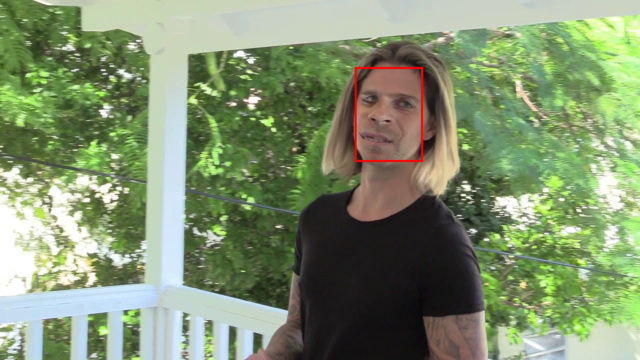

In [23]:

d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while i < 100:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass
